In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor, plot_importance
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor


In [2]:
TRAIN_PATH = 'small_data/s_train.csv'
VAL_PATH = 'small_data/s_val.csv'
TEST_PATH = 'small_data/s_test.csv'

RANDOM_STATE = 42

In [3]:
sns.set()
tqdm.pandas()

In [4]:
def check_estimator(estimator, name, X_train, y_train, X_val, y_val, results):
    estimator.fit(X_train, y_train)

    train_predicts = estimator.predict(X_train)
    val_predicts = estimator.predict(X_val)

    results.loc[name, 'Train RMSE'] = mean_squared_error(y_train, train_predicts, squared=False)
    results.loc[name, 'Val RMSE'] = mean_squared_error(y_val, val_predicts, squared=False)

    
    fig, axes = plt.subplots(1, 2, figsize=(18, 5));
    axes[0].hist(train_predicts, bins=100);
    axes[1].hist(val_predicts, bins=100);
    axes[0].set_title('Train predicts');
    axes[1].set_title('Val predicts');

    return results, estimator

In [5]:
# def fill_u_city(df, ego_id):
#     most_freq_city = df[(df['u'] == 0) & (df['ego_id'] == ego_id)]['city_id_v'].value_counts()
#     city = most_freq_city[(most_freq_city.index > -1)].idxmax()
#     idx = df[(df['u'] == 0) & (df['ego_id'] == ego_id) & (df['city_id_u'] == -1)].index
#     df.loc[idx, 'city_id_u'] = city

#     return df


# def fill_v_city(df, ego_id):
#     city = df[(df['u'] == 0) & (df['ego_id'] == ego_id)]['city_id_u'].unique()[0]
#     idx = df[(df['u'] == 0) & (df['ego_id'] == ego_id) & (df['city_id_v'] == -1)].index
#     df.loc[idx, 'city_id_v'] = city

#     return df

# Train Data

In [14]:
train = pd.read_csv(TRAIN_PATH)
val = pd.read_csv(VAL_PATH)

In [15]:
# ego_ids = train['ego_id'].unique()

# for ego_id in tqdm(ego_ids):
#     train = fill_v_city(train, ego_id)
#     train = fill_u_city(train, ego_id)

# for ego_id in tqdm(val['ego_id'].unique()):
#     val = fill_v_city(val, ego_id)
#     val = fill_u_city(val, ego_id)

# train['same_city'] = train['city_id_u'] == train['city_id_v']
# val['same_city'] = val['city_id_u'] == val['city_id_v']

100%|██████████| 64/64 [00:00<00:00, 115.21it/s]


In [16]:
y_train = train['x1']
X_train = train.drop(columns=['x1'])

y_val = val['x1']
X_val = val.drop(columns=['x1'])

In [17]:
results = pd.DataFrame()

# LightGBM

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

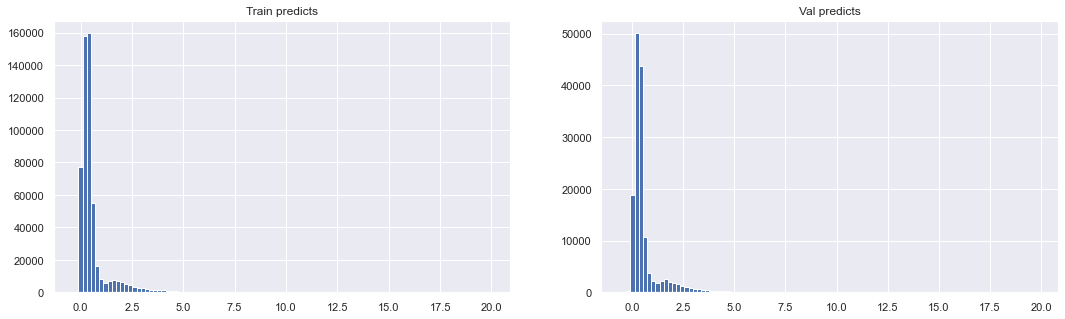

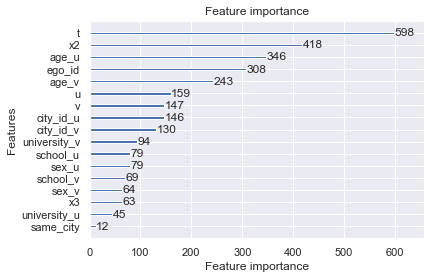

In [18]:
lgbm = LGBMRegressor(random_state=RANDOM_STATE)

results, lgbm = check_estimator(lgbm, 'Lgbm default', X_train, y_train, X_val, y_val, results)

plot_importance(lgbm)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

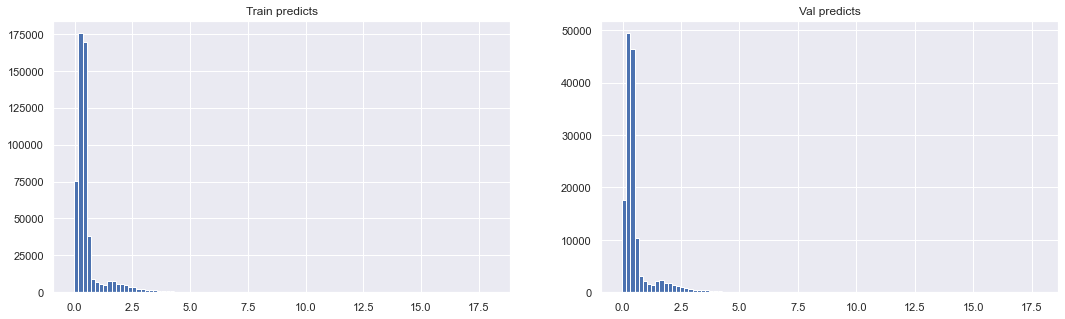

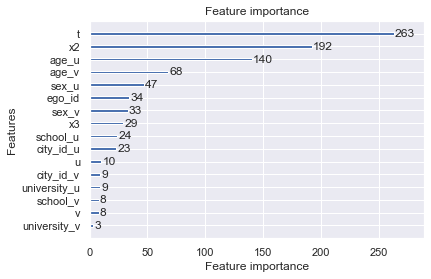

In [19]:
lgbm2 = LGBMRegressor(random_state=RANDOM_STATE, max_depth=10, n_estimators=30)

results, lgbm2 = check_estimator(lgbm2, 'Lgbm max_depth=10 n_estimators=30', X_train, y_train, X_val, y_val, results)

plot_importance(lgbm2)

In [20]:
results

,Train RMSE,Val RMSE
Lgbm default,0.683589,0.721111
Lgbm max_depth=10 n_estimators=30,0.715847,0.726556


# XGBoost

,features,importances
4,x2,0.534813
3,t,0.135084
13,sex_v,0.064324
8,sex_u,0.055182
5,x3,0.053468
6,age_u,0.031563
11,age_v,0.022364
0,ego_id,0.015389
9,school_u,0.014272
7,city_id_u,0.011919


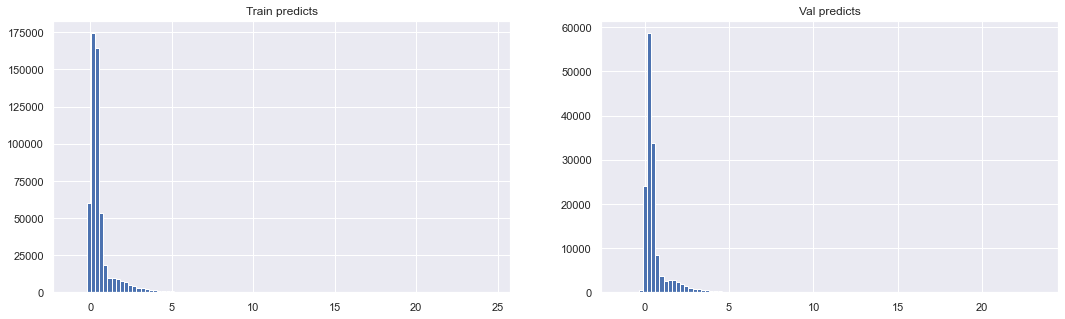

In [11]:
xgb = XGBRegressor(random_state=RANDOM_STATE)

results, xgb = check_estimator(xgb, 'Xgb default', X_train.to_numpy(), y_train.to_numpy(), X_val.to_numpy(), y_val.to_numpy(), results)

pd.DataFrame.from_dict({'features': X_train.columns, 'importances': xgb.feature_importances_}).sort_values('importances', ascending=False)

,features,importances
4,x2,0.638933
3,t,0.075246
8,sex_u,0.044002
13,sex_v,0.043658
5,x3,0.032309
6,age_u,0.023235
11,age_v,0.019065
7,city_id_u,0.015893
12,city_id_v,0.015632
0,ego_id,0.015473


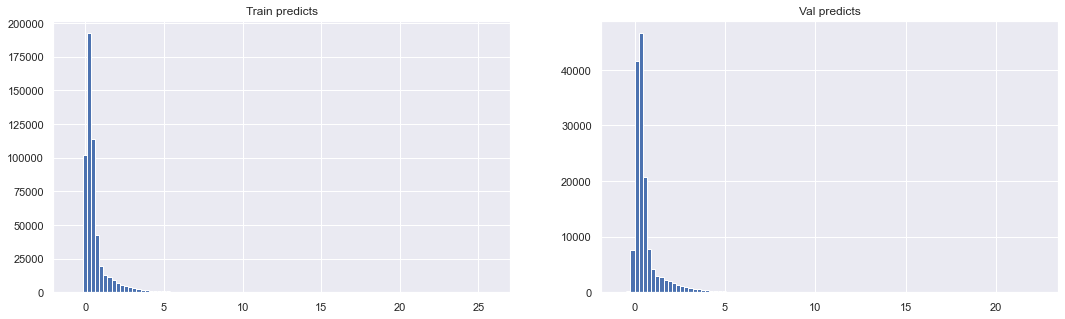

In [12]:
xgb2 = XGBRegressor(random_state=RANDOM_STATE, booster='dart', max_depth=10)

results, xgb2 = check_estimator(xgb2, 'Xgb booster=\'dart\', max_depth=10', X_train.to_numpy(), y_train.to_numpy(), X_val.to_numpy(), y_val.to_numpy(), results)

pd.DataFrame.from_dict({'features': X_train.columns, 'importances': xgb2.feature_importances_}).sort_values('importances', ascending=False)

In [13]:
results

,Train RMSE,Val RMSE
Lgbm default,0.682095,0.722603
Lgbm max_depth=10 n_estimators=30,0.715551,0.726334
Xgb default,0.641810,0.729415
"Xgb booster='dart', max_depth=10",0.504398,0.754974


,features,importances
4,x2,0.638933
3,t,0.075246
8,sex_u,0.044002
13,sex_v,0.043658
5,x3,0.032309
6,age_u,0.023235
11,age_v,0.019065
7,city_id_u,0.015893
12,city_id_v,0.015632
0,ego_id,0.015473


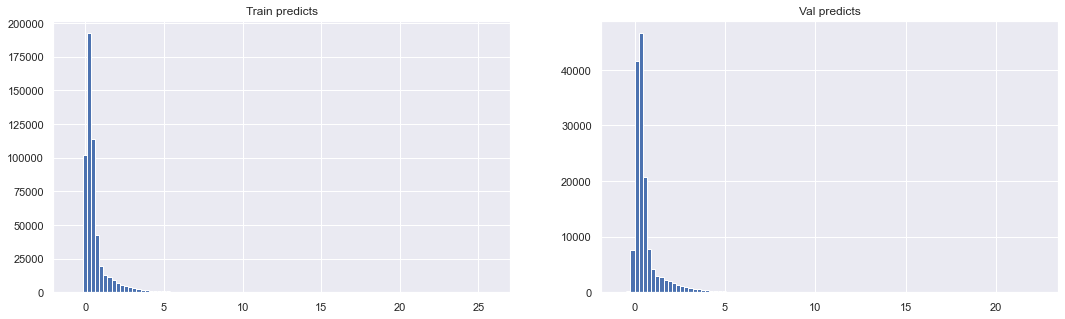

In [14]:
xgb3 = XGBRegressor(random_state=RANDOM_STATE, max_depth=10)

results, xgb3 = check_estimator(xgb3, 'max_depth=10', X_train.to_numpy(), y_train.to_numpy(), X_val.to_numpy(), y_val.to_numpy(), results)

pd.DataFrame.from_dict({'features': X_train.columns, 'importances': xgb3.feature_importances_}).sort_values('importances', ascending=False)

In [15]:
results

,Train RMSE,Val RMSE
Lgbm default,0.682095,0.722603
Lgbm max_depth=10 n_estimators=30,0.715551,0.726334
Xgb default,0.641810,0.729415
"Xgb booster='dart', max_depth=10",0.504398,0.754974
max_depth=10,0.504398,0.754974


# Random Forest

In [16]:
X_train = X_train.replace({np.NaN: -1})
X_val = X_val.replace({np.NaN: -1})

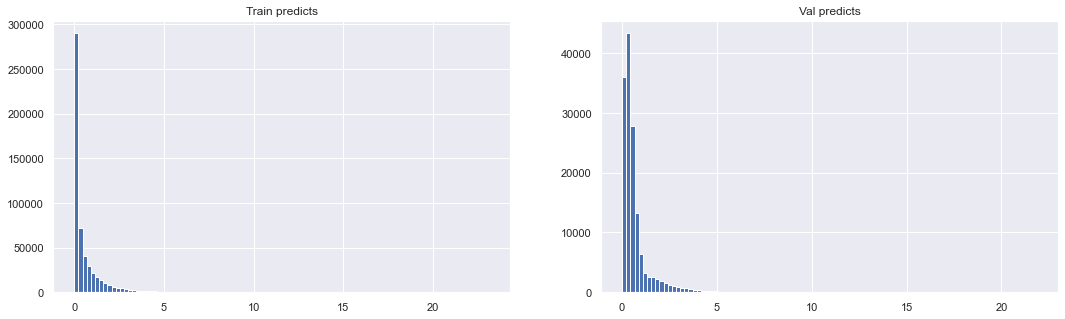

In [17]:
forest = RandomForestRegressor(random_state=RANDOM_STATE)

results, forest = check_estimator(forest, 'forest default', X_train, y_train, X_val, y_val, results)

In [18]:
pd.DataFrame.from_dict({'features': X_train.columns, 'importances': forest.feature_importances_}).sort_values('importances', ascending=False)

,features,importances
4,x2,0.482641
3,t,0.177811
6,age_u,0.047686
1,u,0.043827
2,v,0.041285
11,age_v,0.036929
0,ego_id,0.025787
7,city_id_u,0.025249
12,city_id_v,0.024658
9,school_u,0.020868


In [19]:
results

,Train RMSE,Val RMSE
Lgbm default,0.682095,0.722603
Lgbm max_depth=10 n_estimators=30,0.715551,0.726334
Xgb default,0.641810,0.729415
"Xgb booster='dart', max_depth=10",0.504398,0.754974
max_depth=10,0.504398,0.754974
forest default,0.249275,0.742191


# Extra Trees

In [20]:
# extra = ExtraTreesRegressor(random_state=RANDOM_STATE)

# results, extra = check_estimator(extra, 'extra treees default', X_train, y_train, X_val, y_val, results)

# pd.DataFrame.from_dict({'features': X_train.columns, 'importances': extra.feature_importances_}).sort_values('importances', ascending=False)